## O mesmo sistema de loggings do arquivo ColetaDadosWarrenBuffett.ipynb

In [ ]:
import os
import sys
import logging
from datetime import datetime


# Criar pastas logs/ e outputs/ se não existirem
os.makedirs("logs", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

# Configuração de logging
log_filename = datetime.now().strftime("logs/log_%Y-%m-%d_%H-%M-%S.log")
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler(log_filename, encoding="utf-8"),
        logging.StreamHandler(sys.stdout)
    ],
     force=True
)

# Classe para redirecionar print() para arquivo também
class TeeOutput:
    """Redireciona tudo que seria printado para o terminal e também para um arquivo."""
    def __init__(self, filepath):
        self.file = open(filepath, "a", encoding="utf-8")
        self.terminal = sys.stdout

    def write(self, message):
        self.terminal.write(message)
        self.file.write(message)

    def flush(self):
        self.terminal.flush()
        self.file.flush()

# Redirecionar todos os prints para outputs/
output_filename = datetime.now().strftime("outputs/output_%Y-%m-%d_%H-%M-%S.txt")
sys.stdout = TeeOutput(output_filename)

logging.info("🚀 Logging inicializado com sucesso!")


# Análise Exploratória dos Dados

Este notebook tem como objetivo realizar uma **análise exploratória** dos dados tratados no notebook da coleta.

## Análise 1 — Volume médio diário por empresa

Nesta etapa, será calculado o volume médio diário negociado por empresa.  
O objetivo é identificar quais ativos apresentam maior liquidez no período analisado.

### Etapas:
- Agrupar os dados por ticker;
- Calcular o volume médio diário;
- Exibir uma tabela resumo e um gráfico comparativo.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Garantir que o caminho de saída exista
os.makedirs("outputs/outputsAnalise", exist_ok=True)

# Carregar parquet
df_stocks = pd.read_parquet("data_clean/stock_prices_clean.parquet")

# Verificar colunas
print("Colunas disponíveis:", df_stocks.columns)


In [ ]:
# Agrupar por empresa e calcular média e desvio padrão
volume_stats = df_stocks.groupby("empresa")["volume"].agg(["mean", "std"]).reset_index()
volume_stats = volume_stats.rename(columns={"mean": "Volume Médio", "std": "Desvio Padrão"})

# Formatar os números para ficar mais legível
volume_stats["Volume Médio"] = volume_stats["Volume Médio"].apply(lambda x: int(round(x)))
volume_stats["Desvio Padrão"] = volume_stats["Desvio Padrão"].apply(lambda x: int(round(x)))

# Salvar tabela
volume_stats.to_csv("outputs/outputsAnalise/tabelas/volume_medio_por_empresa.csv", index=False)

# Plotar gráfico
plt.figure(figsize=(8,5))
sns.barplot(data=volume_stats, x="empresa", y="Volume Médio", palette="viridis")

# Deixar o eixo y legível com separador de milhar
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.title("Volume Médio Diário Negociado por Empresa", fontsize=13)
plt.xlabel("Empresa")
plt.ylabel("Volume Médio")
plt.tight_layout()

# Salvar gráfico
plt.savefig("outputs/outputsAnalise/graficos/volume_medio_por_empresa.png", dpi=300)
plt.show()

volume_stats.head()


## Análise 2 — Evolução do preço de fechamento

Nesta seção, será analisada a variação do preço de fechamento ao longo do tempo para cada ticker.  
O objetivo é observar tendências, picos e possíveis períodos de volatilidade.

### Etapas:
- Agrupar dados por ticker e data;
- Plotar um gráfico de linha mostrando a evolução temporal dos preços.

In [ ]:
# Garantir que a coluna 'data' esteja em formato datetime
df_stocks["data"] = pd.to_datetime(df_stocks["data"])

# Ordenar por data (boa prática)
df_stocks = df_stocks.sort_values("data")

# Plotar gráfico de linhas
plt.figure(figsize=(10,6))
sns.lineplot(data=df_stocks, x="data", y="fechamento", hue="ticker", linewidth=1.5)
plt.title("Evolução do Preço de Fechamento ao Longo do Tempo", fontsize=13)
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento em dólar")
plt.legend(title="Ticker")
plt.tight_layout()

# Salvar gráfico
plt.savefig("outputs/outputsAnalise/graficos/evolucao_preco_fechamento.png", dpi=300)
plt.show()


## Análise 3 — Top 10 posições mais valiosas no portfólio

Nesta etapa, será identificada a composição das **10 maiores posições do portfólio da Berkshire Hathaway**, com base no valor de mercado de cada ativo.  
O objetivo é compreender a concentração do portfólio e visualizar quais empresas representam a maior fatia dos investimentos.

### Etapas:
- Calcular o valor de mercado de cada posição no portfólio;
- Ordenar os ativos do maior para o menor valor;
- Selecionar as 10 primeiras posições;
- Exibir os resultados em forma de tabela e gráfico de barras.


In [ ]:
# Garantir que o caminho de saída exista
os.makedirs("outputs/outputsAnalise", exist_ok=True)

# Carregar parquet
df_berkshire = pd.read_parquet("data_clean/movimentacoesBerkshireHathaway_clean.parquet")

# Verificar colunas
print("Colunas disponíveis:", df_berkshire.columns)

In [ ]:
# Ordenar por Valor de Mercado e pegar top 10
top10_valor = df_berkshire.sort_values("Valor de Mercado", ascending=False).head(10)

# Salvar tabela
top10_valor.to_csv("outputs/outputsAnalise/tabelas/top10_valor_mercado.csv", index=False)

# Plotar gráfico de barras
plt.figure(figsize=(10,6))
sns.barplot(data=top10_valor, x="Ação", y="Valor de Mercado", palette="magma")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.title("Top 10 Posições Mais Valiosas do Portfólio", fontsize=13)
plt.xlabel("Ação")
plt.ylabel("Valor de Mercado")
plt.xticks(rotation=45)
plt.tight_layout()

# Salvar gráfico
plt.savefig("outputs/outputsAnalise/graficos/top10_valor_mercado.png", dpi=300)
plt.show()


## Análise 4 — Variação percentual entre o portfólio atual e o anterior

Esta análise compara a **distribuição percentual do portfólio atual** da Berkshire Hathaway com a **distribuição percentual do portfólio anterior**, destacando as mudanças de peso de cada ativo entre os dois períodos.

O gráfico resultante apresenta as ações com **aumento de participação** (barras positivas, em tons de azul) e **redução de participação** (barras negativas, em tons de vermelho).  
Dessa forma, é possível visualizar rapidamente quais posições foram reforçadas e quais foram reduzidas.

### Etapas:
- Calcular a diferença entre as colunas “% do Portfólio” e “% Anterior do Portfólio”;  
- Gerar uma nova coluna com essa diferença percentual;  
- Ordenar as ações pela variação, destacando as maiores altas e quedas;  
- Plotar um gráfico de barras com a diferença percentual por ação.


In [ ]:
# Criar coluna de diferença
df_berkshire["Diferença % Portfólio"] = df_berkshire["% do Portfólio"] - df_berkshire["% Anterior do Portfólio"]

# Salvar tabela
df_berkshire[["Ação", "% do Portfólio", "% Anterior do Portfólio", "Diferença % Portfólio"]].to_csv(
    "outputs/outputsAnalise/tabelas/comparacao_percentual_portfolio.csv", index=False
)

# Plotar gráfico de barras
plt.figure(figsize=(10,6))
sns.barplot(data=df_berkshire.sort_values("Diferença % Portfólio", ascending=False),
            x="Ação", y="Diferença % Portfólio", palette="coolwarm")
plt.title("Diferença entre % do Portfólio e % Anterior do Portfólio", fontsize=13)
plt.xlabel("Ação")
plt.ylabel("Diferença (%)")
plt.xticks(rotation=45)
plt.tight_layout()

# Salvar gráfico
plt.savefig("outputs/outputsAnalise/graficos/diferenca_percentual_portfolio.png", dpi=300)
plt.show()


## Análise 5 — Distribuição das variações percentuais nas posições

Nesta análise, é examinada a **distribuição do percentual de mudança nas posições do portfólio** da Berkshire Hathaway.  
O objetivo é entender o comportamento geral das alterações — se as posições tendem a sofrer pequenas variações ou mudanças mais expressivas.

O gráfico apresenta um **histograma com curva de densidade (KDE)**, mostrando a frequência relativa dos valores de “% de Mudança”.  
Isso permite visualizar se as modificações no portfólio estão concentradas em torno de pequenas variações ou se há presença de extremos.

### Etapas:
- Selecionar a coluna “% de Mudança” para todas as ações;  
- Gerar um histograma com curva de densidade (KDE) para representar a distribuição das variações;  
- Analisar a simetria e dispersão da distribuição, identificando padrões de ajuste ou reposicionamento de ativos.


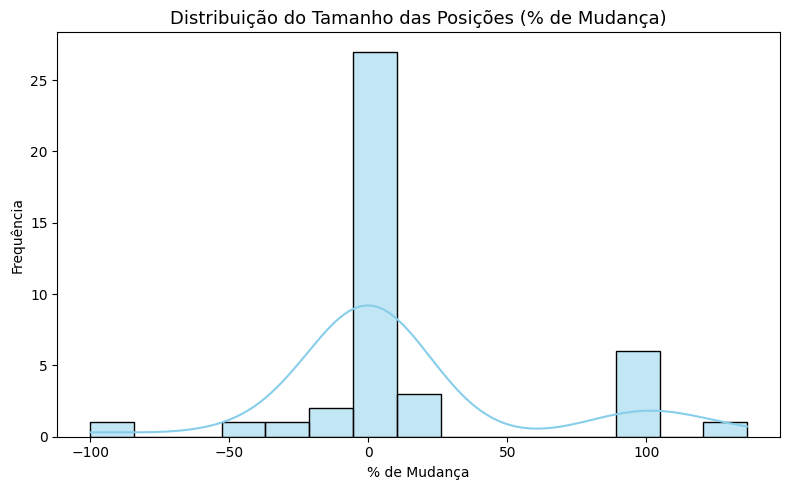

In [ ]:
# Salvar tabela de % de mudança
df_berkshire[["Ação", "% de Mudança"]].to_csv(
    "outputs/outputsAnalise/distribuicao_percentual_mudanca.csv", index=False
)

# Plotar histograma
plt.figure(figsize=(8,5))
sns.histplot(df_berkshire["% de Mudança"], bins=15, kde=True, color="skyblue")
plt.title("Distribuição do Tamanho das Posições (% de Mudança)", fontsize=13)
plt.xlabel("% de Mudança")
plt.ylabel("Frequência")
plt.tight_layout()

# Salvar gráfico
plt.savefig("outputs/outputsAnalise/graficos/distribuicao_percentual_mudanca.png", dpi=300)
plt.show()


## Análise 6 — Ações com maior frequência de mudanças

Esta análise identifica **quais ações apresentaram maior frequência ou intensidade de mudanças** nas suas posições ao longo do tempo.  
O objetivo é destacar os ativos que sofreram **as maiores alterações acumuladas** — seja por compras, vendas ou ajustes de quantidade de ações.

O gráfico de barras exibe o total agregado de “Mudança em Ações” por ticker, ordenado do maior para o menor, permitindo observar quais ativos tiveram movimentações mais significativas.

### Etapas:
- Agrupar os dados por ação (`ticker`);  
- Somar o total de “Mudança em Ações” para cada ativo;  
- Ordenar do maior para o menor valor agregado;  
- Plotar um gráfico de barras mostrando os ativos com maior volume total de alterações.


In [ ]:
# Agrupar por ação e somar mudanças
freq_mudancas = df_berkshire.groupby("Ação")["Mudança em Ações"].sum().reset_index()
freq_mudancas = freq_mudancas.sort_values("Mudança em Ações", ascending=False)

# Salvar tabela
freq_mudancas.to_csv("outputs/outputsAnalise/tabelas/acoes_maior_frequencia_mudanca.csv", index=False)

# Plotar gráfico de barras
plt.figure(figsize=(10,6))
sns.barplot(data=freq_mudancas, x="Ação", y="Mudança em Ações", palette="plasma")
plt.title("Ações com Maior Frequência de Mudança", fontsize=13)
plt.xlabel("Ação")
plt.ylabel("Mudança em Ações")
plt.xticks(rotation=45)
plt.tight_layout()

# Salvar gráfico
plt.savefig("outputs/outputsAnalise/graficos/acoes_maior_frequencia_mudanca.png", dpi=300)
plt.show()


## Análise 7 — Palavras mais frequentes nos títulos das notícias

Nesta análise, é realizado um levantamento das **30 palavras mais recorrentes nos títulos das notícias** relacionadas à Berkshire Hathaway e Warren Buffett.  
O objetivo é identificar **os principais temas e tópicos de destaque** que aparecem com maior frequência na cobertura jornalística.

O processo envolve a limpeza e tokenização dos textos, remoção de *stopwords* (palavras comuns sem significado analítico, em português e inglês) e posterior contagem da frequência de ocorrência de cada termo.

O resultado é apresentado em um gráfico de barras, que evidencia visualmente os termos mais mencionados nos títulos.

### Etapas:
- Consolidar todos os títulos de notícias em um único texto;  
- Remover pontuação e palavras irrelevantes (*stopwords*);  
- Tokenizar e contar a frequência de cada palavra;  
- Selecionar as 30 mais frequentes;  
- Gerar uma tabela e um gráfico de barras com as palavras mais recorrentes.


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from collections import Counter
from nltk.corpus import stopwords

# Garantir que o caminho de saída exista
os.makedirs("outputs/outputsAnalise/tabelas", exist_ok=True)
os.makedirs("outputs/outputsAnalise/graficos", exist_ok=True)

# Baixar stopwords do NLTK
nltk.download("stopwords", quiet=True)

# Stopwords em português e inglês
stop_words = set(stopwords.words("portuguese")) | set(stopwords.words("english"))

# Carregar parquet
df_news = pd.read_parquet("data_clean/news_buffett_clean.parquet")

# Verificar colunas disponíveis
print("Colunas disponíveis:", df_news.columns)



In [ ]:
# Juntar todos os títulos e limpar texto
titulos = " ".join(df_news["titulo"].dropna().astype(str)).lower()

# Tokenizar com regex (mantém acentos e ignora pontuação)
tokens = re.findall(r"\b[a-záàâãéèêíïóôõöúçñ]{3,}\b", titulos)

# Remover stopwords
tokens_filtrados = [t for t in tokens if t not in stop_words]

# Contar palavras e criar DataFrame
contagem = Counter(tokens_filtrados)
df_freq = pd.DataFrame(contagem.most_common(30), columns=["Palavra", "Frequência"])

# Salvar tabela
df_freq.to_csv("outputs/outputsAnalise/tabelas/top20_palavras_titulos.csv", index=False)

# Plotar gráfico
plt.figure(figsize=(10,6))
sns.barplot(data=df_freq, x="Palavra", y="Frequência", palette="magma")
plt.title("Top 30 Palavras Mais Frequentes nos Títulos das Notícias", fontsize=13)
plt.xlabel("Palavra")
plt.ylabel("Frequência")
plt.xticks(rotation=45)
plt.tight_layout()

# Salvar gráfico
plt.savefig("outputs/outputsAnalise/graficos/top30_palavras_titulos.png", dpi=300)
plt.show()


## Análise 8 — Quantidade de notícias por termo pesquisado

Esta análise quantifica o **número de notícias coletadas para cada termo pesquisado** (por exemplo, “Buffett”, “Berkshire”, entre outros).  
O objetivo é avaliar **a distribuição das notícias por tema**, identificando quais termos receberam maior volume de cobertura na base de dados utilizada.

O gráfico de barras facilita a comparação direta entre os termos, destacando visualmente os tópicos mais explorados.

### Etapas:
- Contar a quantidade de notícias associadas a cada termo pesquisado;  
- Organizar os resultados em ordem decrescente de frequência;  
- Exibir um gráfico de barras com a quantidade de notícias por termo;  
- Exportar a tabela resumo com os valores calculados.


In [ ]:
# Contar número de notícias por termo
termo_counts = df_news['termo'].value_counts().reset_index()
termo_counts.columns = ['termo', 'quantidade']

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=termo_counts, x='quantidade', y='termo', palette='viridis')
plt.title('Quantidade de Notícias por Termo Pesquisado')
plt.xlabel('Quantidade de Notícias')
plt.ylabel('Termo')
plt.tight_layout()
plt.savefig(os.path.join("outputs/outputsAnalise/graficos", "news_quantidade_por_termo.png"), dpi=300)
plt.show()

# Salvar CSV
termo_counts.to_csv(os.path.join("outputs/outputsAnalise/tabelas", "news_quantidade_por_termo.csv"), index=False)

logging.info("✅ Todas as análises concluídas e salvas em: outputs/outputsAnalise/")